<a href="https://colab.research.google.com/github/feresk/Brain-tumor/blob/master/Brain_Tumor_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Imports**

In [ ]:
from numpy.random import seed
seed(127)
import tensorflow as tf

In [ ]:
tf.random.set_seed(31)
import os
import numpy as np

from datetime import datetime, timedelta
from time import strftime
from PIL import Image, ImageOps

#**Constants**

In [ ]:
X_TRAIN_PATH = 'BTDS/brain_tumor_xtrain.csv'
X_TEST_PATH = 'BTDS/brain_tumor_xtest.csv'
Y_TRAIN_PATH = 'BTDS/brain_tumor_ytrain.csv'
Y_TEST_PATH = 'BTDS/brain_tumor_ytest.csv'

LOGGING_PATH = 'tensorboard_btds_digit_logs/'

NR_CLASSES = 2  # 0 or 1
VALIDATION_SIZE = 219
IMAGE_WIDTH = 200
IMAGE_HEIGHT = 200
CHANNELS  = 1
TOTAL_INPUTS = IMAGE_HEIGHT * IMAGE_WIDTH * CHANNELS

#**Get the Data**

In [ ]:
yTrainAll = np.loadtxt(Y_TRAIN_PATH, delimiter=',', dtype=int)
yTest = np.loadtxt(Y_TEST_PATH, delimiter=',', dtype=int )
xTrainAll = np.loadtxt(X_TRAIN_PATH, delimiter=',', dtype=int)
xTest = np.loadtxt(X_TEST_PATH, delimiter=',', dtype=int )

In [ ]:
xTrainAll.shape

(1619, 40000)

In [ ]:
yTrainAll.shape

(1619,)

#**Data Preprocessing**

In [ ]:
xTrainAll, xTest = xTrainAll/255.0, xTest/255.0

In [ ]:
yTrainAll[:5]

array([0, 1, 1, 1, 1])

In [ ]:
yTrainAll = np.eye(NR_CLASSES)[yTrainAll]

In [ ]:
xTrainAll

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.05882353, 0.05098039,
        0.03529412],
       [0.76078431, 0.75294118, 0.69019608, ..., 0.08235294, 0.08235294,
        0.08627451],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.12156863, 0.12156863, 0.12156863, ..., 0.12156863, 0.11764706,
        0.11764706],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

**Create validation dataset from training data**

In [ ]:
xVal = xTrainAll[:VALIDATION_SIZE]
yVal = yTrainAll[:VALIDATION_SIZE]
xTrain = xTrainAll[VALIDATION_SIZE:]
yTrain = yTrainAll[VALIDATION_SIZE:]

#**Setup Tensorflow Graph**

In [ ]:
tf.compat.v1.disable_eager_execution()
X = tf.compat.v1.placeholder(tf.float32, shape=[None, TOTAL_INPUTS], name='X')
Y = tf.compat.v1.placeholder(tf.float32, shape=[None, NR_CLASSES], name='results')

In [ ]:
nrEpochs = 15
learningRate = 1e-4

# ===== Best neural network so far ===== #
nHidden1 = 512
nHidden2 = 256
nHidden3 = 32
# nHidden4 = 16
# nHidden5 = 3

# nHidden1 = 1024
# nHidden2 = 316
# nHidden3 = 126
# nHidden4 = 24
# nHidden5 = 3



In [ ]:
def setupLayer(input, weightDim, biasDim, name):
  with tf.name_scope(name):
    initialW = tf.compat.v1.truncated_normal(shape=weightDim, stddev=.1, seed=42 )
    w = tf.Variable(initial_value=initialW, name='W')

    initialB = tf.constant(value=0.0, shape=biasDim)
    b = tf.Variable(initial_value=initialB, name='B')

    layerIn = tf.matmul(input, w) + b

    if name == 'out' :
      layerOut = tf.nn.softmax(layerIn)
    else : 
      layerOut = tf.nn.relu(layerIn)

    tf.compat.v1.summary.histogram('weights', w)
    tf.compat.v1.summary.histogram('biases', b)

    return layerOut

In [ ]:
layer1 = setupLayer(X, [TOTAL_INPUTS, nHidden1], [nHidden1], 'layer_1')

layer2 = setupLayer(layer1, [nHidden1, nHidden2], [nHidden2], 'layer_2')
layer3 = setupLayer(layer2, [nHidden2, nHidden3], [nHidden3], 'layer_3')
output = setupLayer(layer3, [nHidden3, NR_CLASSES], [NR_CLASSES], 'out')

# layer4 = setupLayer(layer3, [nHidden3, nHidden4], [nHidden4], 'layer_4')
# layer5 = setupLayer(layer4, [nHidden4, nHidden5], [nHidden5], 'layer_5')
# output = setupLayer(layer5, [nHidden5, NR_CLASSES], [NR_CLASSES], 'out')

modelName = f'{nHidden1}-{nHidden2}-{nHidden3} LR{learningRate} E{nrEpochs}'

#**Tensorboard Setup**

In [ ]:
#Folder for Tensorboard
from datetime import *
folderName = f'{modelName} at {datetime.now(timezone(timedelta(hours=1))).strftime("%H:%M")}'
directory = os.path.join(LOGGING_PATH, folderName)

try:
  os.makedirs(directory)
except OSError:
  print("Error")
else:
  print('Successfully created Directories!')

Successfully created Directories!


#**Loss, Optimisation & Metrics**

In [ ]:
with tf.name_scope('Loss_Calc'):
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=output))

with tf.name_scope('Optimizer'):
  optimizer = tf.compat.v1.train.AdamOptimizer(learningRate)
  trainStep = optimizer.minimize(loss)

with tf.name_scope('Accuracy_Calc'):
  correctPred = tf.equal(tf.argmax(output,axis=1), tf.argmax(Y,axis=1))
  accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

In [ ]:
with tf.name_scope('Performance'):
  tf.compat.v1.summary.scalar('Accuracy', accuracy)
  tf.compat.v1.summary.scalar('Cost', loss)

#**Run Session**

In [ ]:
sess = tf.compat.v1.Session()

In [ ]:
mergedSummary = tf.compat.v1.summary.merge_all()

trainWriter = tf.compat.v1.summary.FileWriter(directory + '/train')
trainWriter.add_graph(sess.graph)

validationWriter = tf.compat.v1.summary.FileWriter(directory + '/validation')

In [ ]:
from tensorflow.python.ops.variables import global_variables_initializer

init = tf.compat.v1.global_variables_initializer()
sess.run(init)

In [ ]:
yTrain.shape

(1400, 2)

In [ ]:
sizeOfBatch = 140

In [ ]:
numExamples = yTrain.shape[0]
nrIterations = int(numExamples / sizeOfBatch)
#nrIterations = round(numExamples / sizeOfBatch)

indexInEpoch = 0

In [ ]:
def nextBatch(batchSize, data, labels):
  global numExamples
  global indexInEpoch

  start = indexInEpoch
  indexInEpoch += batchSize
  end = indexInEpoch

  if indexInEpoch > numExamples :
    start = 0
    indexInEpoch = batchSize

  return data[start:end], labels[start:end]

In [ ]:
for epoch in range(nrEpochs) :

  # =================== Training Dataset =======================
  for i in range(nrIterations) :
    batchX, batchY = nextBatch(sizeOfBatch, xTrain, yTrain)
    feedDictionary = {X:batchX, Y:batchY}

    sess.run(trainStep, feed_dict=feedDictionary)
    
  s, batchAccuracy = sess.run(fetches=[mergedSummary, accuracy], feed_dict=feedDictionary)
  
  trainWriter.add_summary(s, epoch)
  
  print(f'Epoch {epoch} \t| Training Accuracy = {batchAccuracy}')

  # =================== Validation =======================
  summary, accu = sess.run(fetches=[mergedSummary, accuracy], feed_dict={X:xVal, Y:yVal})
  
  print(f'Epoch {epoch} \t| Validation Accuracy = {accu}')
  
  validationWriter.add_summary(summary, epoch)
print('Done Training !!!')

Epoch 0 	| Training Accuracy = 0.6928571462631226
Epoch 0 	| Validation Accuracy = 0.7260273694992065
Epoch 1 	| Training Accuracy = 0.7642857432365417
Epoch 1 	| Validation Accuracy = 0.7534246444702148
Epoch 2 	| Training Accuracy = 0.8214285969734192
Epoch 2 	| Validation Accuracy = 0.8082191944122314
Epoch 3 	| Training Accuracy = 0.8785714507102966
Epoch 3 	| Validation Accuracy = 0.8173515796661377
Epoch 4 	| Training Accuracy = 0.8999999761581421
Epoch 4 	| Validation Accuracy = 0.8310502171516418
Epoch 5 	| Training Accuracy = 0.9071428775787354
Epoch 5 	| Validation Accuracy = 0.853881299495697
Epoch 6 	| Training Accuracy = 0.9285714030265808
Epoch 6 	| Validation Accuracy = 0.8630136847496033
Epoch 7 	| Training Accuracy = 0.9428571462631226
Epoch 7 	| Validation Accuracy = 0.853881299495697
Epoch 8 	| Training Accuracy = 0.9428571462631226
Epoch 8 	| Validation Accuracy = 0.853881299495697
Epoch 9 	| Training Accuracy = 0.9642857313156128
Epoch 9 	| Validation Accuracy = 0.

In [ ]:
def makePrediction(imgPath) :
  img = Image.open('BTDS/'+imgPath).resize((200, 200))
  bw = img.convert('L')
  imgArray = np.array(bw)
  testImg = imgArray.ravel()
  prediction = sess.run(fetches=tf.argmax(output, axis=1), feed_dict={X:[testImg]})

  img.show()
  print(f'Prediction for test Image is {prediction}')

  return img, prediction

Prediction for test Image is [1]


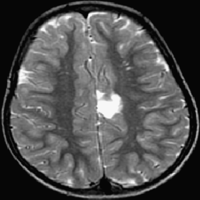

In [ ]:
m = makePrediction('test_img1.jpg')[0]
m

Prediction for test Image is [1]


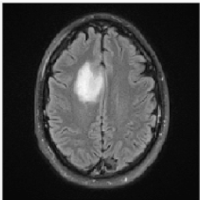

In [ ]:
m = makePrediction('test_img2.png')[0]
m

Prediction for test Image is [0]


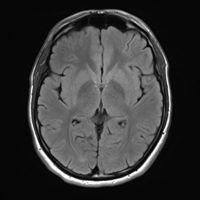

In [ ]:
m = makePrediction('test_img3.jpg')[0]
m

Prediction for test Image is [0]


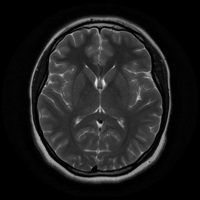

In [ ]:
m = makePrediction('test_img4.jpg')[0]
m

Prediction for test Image is [0]


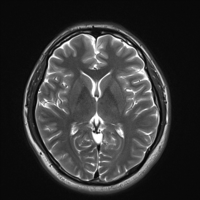

In [ ]:
m = makePrediction('test_img5.jpg')[0]
m

Prediction for test Image is [1]


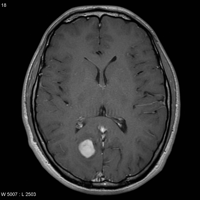

In [ ]:
m = makePrediction('test_img6.jpg')[0]
m

In [ ]:
trainWriter.close()
sess.close()
validationWriter.close()
tf.compat.v1.reset_default_graph()

In [ ]:
# import shutil

# shutil.rmtree('tensorboard_btds_digit_logs')